# Systematic PyTorch MLP Improvements (F1 Lap Time Prediction)
This notebook implements the full improvement roadmap (Parts 1?7): feature engineering, architecture variants, loss experiments, training dynamics, Optuna search (optional), ensembling, and a final comparison table.


In [1]:
from pathlib import Path
import sys

def find_project_root(start: Path) -> Path:
    for parent in [start] + list(start.parents):
        if (parent / "src").is_dir() and (parent / "requirements.txt").exists():
            return parent
    return start

project_root = find_project_root(Path.cwd().resolve())
sys.path.insert(0, str(project_root))
print("Project root:", project_root)


Project root: C:\Users\tvcar\ml_f1\ml_f1


In [2]:
%load_ext autoreload
%autoreload 2


## Setup


In [3]:
import os
import time
import random
from dataclasses import dataclass

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from src.data_loader import enable_cache, load_laps_for_seasons, clean_laps
from src.features import build_feature_table
from src.evaluator import chronological_split, compute_time_series_quality_metrics
from src.visualization import setup_f1_style, plot_model_quality_scorecard
from src.feature_enhancements import add_enhanced_features
from src.torch_tabular_models import build_model

setup_f1_style()

RANDOM_STATE = 42

def seed_everything(seed: int = 42) -> None:
    os.environ["PYTHONHASHSEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(RANDOM_STATE)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DEVICE


device(type='cpu')

## Data: Load cached feature table


In [4]:
from pathlib import Path

DATA_DIR = Path('data')
CACHE_DIR = DATA_DIR / 'cache'
PROCESSED_DIR = DATA_DIR / 'processed'
FEATURES_PATH = PROCESSED_DIR / 'feature_table.parquet'

YEARS = [2022, 2023]  # methodological default; add 2024 only if you want (distribution shift)

enable_cache(CACHE_DIR)


WindowsPath('data/cache')

In [5]:
def load_features_table() -> pd.DataFrame:
    if FEATURES_PATH.exists():
        return pd.read_parquet(FEATURES_PATH)

    raw = load_laps_for_seasons(YEARS, cache_dir=CACHE_DIR)
    clean = clean_laps(raw)
    feature_df, _, _ = build_feature_table(clean)
    PROCESSED_DIR.mkdir(parents=True, exist_ok=True)
    feature_df.to_parquet(FEATURES_PATH, index=False)
    return feature_df

feature_df = load_features_table()
feature_df.head()


,LapNumber,Stint,TyreLife,LapTimeLag1,LapTimeLag2,LapTimeLag3,RollingMean3,Driver,Team,Compound,TrackStatusFlag,Circuit,LapTimeSeconds,Season,RoundNumber,EventName
0,2.0,1.0,2.0,NaN,NaN,NaN,NaN,ALB,Williams,SOFT,green,Sakhir,100.548,2022,1,Bahrain Grand Prix
1,3.0,1.0,3.0,100.548,NaN,NaN,100.548000,ALB,Williams,SOFT,green,Sakhir,100.664,2022,1,Bahrain Grand Prix
2,4.0,1.0,4.0,100.664,100.548,NaN,100.606000,ALB,Williams,SOFT,green,Sakhir,101.126,2022,1,Bahrain Grand Prix
3,5.0,1.0,5.0,101.126,100.664,100.548,100.779333,ALB,Williams,SOFT,green,Sakhir,102.303,2022,1,Bahrain Grand Prix
4,6.0,1.0,6.0,102.303,101.126,100.664,101.364333,ALB,Williams,SOFT,green,Sakhir,101.708,2022,1,Bahrain Grand Prix


In [6]:
# STEP 1: Aggressive filtering to remove polluted laps

def filter_racing_laps(df: pd.DataFrame, verbose: bool = True) -> pd.DataFrame:
    """Remove laps that do not represent normal racing conditions."""
    out = df.copy()
    initial_count = len(out)

    # 1) Track status: keep only green/yellow (no SC/VSC/red)
    if "TrackStatus" in out.columns:
        out = out[out["TrackStatus"].isin([1, 2])].copy()
    elif "TrackStatusFlag" in out.columns:
        ts = out["TrackStatusFlag"].astype(str).str.lower()
        out = out[ts.isin(["green", "yellow"])].copy()

    # 2) Remove formation/cool-down laps
    if "LapNumber" in out.columns:
        out = out[out["LapNumber"] > 1].copy()
        last_laps = out.groupby(["Season", "RoundNumber", "Driver"], dropna=False)["LapNumber"].transform("max")
        out = out[out["LapNumber"] < last_laps].copy()

    # 3) Remove outlier lap times using per-circuit thresholds
    if "Circuit" in out.columns and "LapTimeSeconds" in out.columns:
        circuit_stats = (
            out.groupby("Circuit", dropna=False)["LapTimeSeconds"]
            .agg(["median", "std"])
            .reset_index()
        )
        circuit_stats["std"] = circuit_stats["std"].fillna(0.0)
        out = out.merge(circuit_stats, on="Circuit", how="left", suffixes=("", "_circuit"))
        lower_bound = out["median"] - 3.0 * out["std"]
        upper_bound = out["median"] + 3.0 * out["std"]
        out = out[(out["LapTimeSeconds"] >= lower_bound) & (out["LapTimeSeconds"] <= upper_bound)].copy()
        out = out.drop(columns=["median", "std"])

    # 4) Remove in/out laps if pit markers exist, else heuristic on local rolling median
    if ("PitInTime" in out.columns) or ("PitOutTime" in out.columns):
        pit_in = out["PitInTime"].isna() if "PitInTime" in out.columns else True
        pit_out = out["PitOutTime"].isna() if "PitOutTime" in out.columns else True
        out = out[pit_in & pit_out].copy()
    else:
        out = out.sort_values(["Season", "RoundNumber", "Driver", "LapNumber"]).copy()
        rolling_median = out.groupby(["Season", "RoundNumber", "Driver"], dropna=False)["LapTimeSeconds"].transform(
            lambda x: x.rolling(5, min_periods=1, center=True).median()
        )
        pct_deviation = (out["LapTimeSeconds"] - rolling_median) / rolling_median
        out = out[pct_deviation < 0.20].copy()

    # 5) Remove first 3 laps of each stint (tyre warm-up)
    if "TyreLife" in out.columns:
        out = out[out["TyreLife"] > 3].copy()

    out = out.reset_index(drop=True)
    if verbose:
        final_count = len(out)
        print(f"Lap filtering: {initial_count:,} ? {final_count:,} ({100*final_count/max(initial_count,1):.1f}% retained)")
        print(f"Removed {initial_count - final_count:,} non-representative laps")
    return out


def create_residual_target(df: pd.DataFrame) -> pd.DataFrame:
    """Create baseline prediction and residual target: LapTimeSeconds - baseline."""
    out = df.copy()

    out["baseline"] = out["RollingMean3"].copy()
    out["baseline"] = out["baseline"].fillna(out["LapTimeLag1"])
    out["baseline"] = out["baseline"].fillna(out["LapTimeLag2"])
    out["baseline"] = out["baseline"].fillna(out["LapTimeLag3"])

    driver_session_median = out.groupby(["Season", "RoundNumber", "Driver"], dropna=False)["LapTimeSeconds"].transform("median")
    out["baseline"] = out["baseline"].fillna(driver_session_median)

    out["target_residual"] = out["LapTimeSeconds"] - out["baseline"]

    print("Residual target statistics:")
    print(f"  Mean:   {out['target_residual'].mean():.3f}s")
    print(f"  Std:    {out['target_residual'].std():.3f}s")
    print(f"  Range:  [{out['target_residual'].min():.2f}, {out['target_residual'].max():.2f}]")

    return out


def add_degradation_features(df: pd.DataFrame) -> pd.DataFrame:
    """Add features that explain lap-to-lap variation (for residual modeling)."""
    out = df.copy()

    out["instant_deg"] = (out["LapTimeLag1"] - out["LapTimeLag2"]).fillna(0.0)

    typical_stint_length = 25.0
    out["stint_progress"] = (out["TyreLife"].astype(float) / typical_stint_length).clip(0, 1.5)

    out["TyreLife_sq"] = out["TyreLife"].astype(float) ** 2
    out["TyreLife_sqrt"] = np.sqrt(out["TyreLife"].astype(float).clip(lower=0))

    compound_deg_rate = {
        "SOFT": 0.05,
        "MEDIUM": 0.03,
        "HARD": 0.02,
        "INTERMEDIATE": 0.04,
        "WET": 0.03,
    }
    comp = out["Compound"].astype(str).str.upper()
    out["expected_deg"] = comp.map(compound_deg_rate).fillna(0.03) * out["TyreLife"].astype(float)
    out["deg_vs_expected"] = out["instant_deg"] - comp.map(compound_deg_rate).fillna(0.03)

    out = out.sort_values(["Season", "RoundNumber", "Driver", "Stint", "LapNumber"]).copy()
    out["deg_accel"] = out.groupby(["Season", "RoundNumber", "Driver", "Stint"], dropna=False)["instant_deg"].diff().fillna(0.0)

    return out


feature_df_clean = filter_racing_laps(feature_df, verbose=True)
feature_df_clean = create_residual_target(feature_df_clean)
feature_df_clean = add_degradation_features(feature_df_clean)

print("
Lap time distribution after filtering:")
print(feature_df_clean["LapTimeSeconds"].describe())
print(f"
Max lap time: {feature_df_clean['LapTimeSeconds'].max():.1f}s")
print(f"Laps > 120s remaining: {(feature_df_clean['LapTimeSeconds'] > 120).sum()}")

# Apply split AFTER filtering and baseline computation
train_df, test_df = chronological_split(feature_df_clean, split_season=2023)

# Fill any remaining NaN baselines using training median baseline
train_baseline_median = float(train_df["baseline"].median())
train_df["baseline"] = train_df["baseline"].fillna(train_baseline_median)
test_df["baseline"] = test_df["baseline"].fillna(train_baseline_median)

# Recalculate residual target after filling
train_df["target_residual"] = train_df["LapTimeSeconds"] - train_df["baseline"]
test_df["target_residual"] = test_df["LapTimeSeconds"] - test_df["baseline"]

pd.Series({
    'train_rows': len(train_df),
    'test_rows': len(test_df),
    'train_seasons': sorted(train_df['Season'].unique().tolist()),
    'test_seasons': sorted(test_df['Season'].unique().tolist()),
})


train_rows              30978
test_rows                9944
train_seasons    [2022, 2023]
test_seasons           [2023]
dtype: object

## PART 1: Feature Engineering
This section expands the feature space *without touching the architecture*.


In [7]:
# Base columns used by all models (now includes degradation-focused features)
BASE_NUMERIC_COLS = [
    'LapNumber',
    'Stint',
    'TyreLife',
    'TyreLife_sq',
    'TyreLife_sqrt',
    'LapTimeLag1',
    'LapTimeLag2',
    'LapTimeLag3',
    'RollingMean3',
    'instant_deg',
    'stint_progress',
    'expected_deg',
    'deg_vs_expected',
    'deg_accel',
]

CATEGORICAL_COLS = [
    'Driver',
    'Team',
    'Compound',
    'Circuit',
    'TrackStatusFlag',
]

# Residual target (model predicts deviations from baseline)
TARGET_COL = 'target_residual'

# Keep these for reconstruction/evaluation
REQUIRED_EXTRA_COLS = ['LapTimeSeconds', 'baseline']

for c in BASE_NUMERIC_COLS + CATEGORICAL_COLS + [TARGET_COL] + REQUIRED_EXTRA_COLS:
    if c not in train_df.columns:
        raise KeyError(f'Missing column: {c}')


In [8]:
# Apply engineered features (train-fit, no leakage)
train_fe, test_fe, added_cols = add_enhanced_features(train_df, test_df)

NUMERIC_COLS_FE = BASE_NUMERIC_COLS + added_cols

print('Added engineered cols:', len(added_cols))
print('Total numeric cols:', len(NUMERIC_COLS_FE))
train_fe[NUMERIC_COLS_FE + CATEGORICAL_COLS + [TARGET_COL, 'LapTimeSeconds', 'baseline']].head()


Added engineered cols: 21
Total numeric cols: 28


,LapNumber,Stint,TyreLife,LapTimeLag1,LapTimeLag2,LapTimeLag3,RollingMean3,LapNumber_sin,LapNumber_cos,TyreDegradationRate,...,TyreLife_x_HARD,driver_circuit_median_pace,team_circuit_median_pace,driver_compound_median_degradation,Driver,Team,Compound,Circuit,TrackStatusFlag,LapTimeSeconds
0,2.0,1.0,2.0,NaN,NaN,NaN,NaN,0.218681,0.975796,0.000000,...,0.0,99.299,99.626,0.00518,ALB,Williams,SOFT,Sakhir,green,100.548
1,3.0,1.0,3.0,100.548,NaN,NaN,100.548000,0.324699,0.945817,0.000000,...,0.0,99.299,99.626,0.00518,ALB,Williams,SOFT,Sakhir,green,100.664
2,4.0,1.0,4.0,100.664,100.548,NaN,100.606000,0.426776,0.904357,0.038667,...,0.0,99.299,99.626,0.00518,ALB,Williams,SOFT,Sakhir,green,101.126
3,5.0,1.0,5.0,101.126,100.664,100.548,100.779333,0.523673,0.851919,0.115500,...,0.0,99.299,99.626,0.00518,ALB,Williams,SOFT,Sakhir,green,102.303
4,6.0,1.0,6.0,102.303,101.126,100.664,101.364333,0.614213,0.789141,0.235400,...,0.0,99.299,99.626,0.00518,ALB,Williams,SOFT,Sakhir,green,101.708


## Preprocessing (impute + scale numeric, encode categoricals)


In [9]:
@dataclass
class CategoryEncoder:
    mapping: dict[str, int]

    def transform(self, series: pd.Series) -> np.ndarray:
        s = series.astype(str).fillna('<NA>')
        return np.array([self.mapping.get(v, 0) for v in s], dtype=np.int64)


def fit_category_encoder(train_series: pd.Series, min_freq: int = 2) -> CategoryEncoder:
    s = train_series.astype(str).fillna('<NA>')
    counts = s.value_counts()
    kept = counts[counts >= min_freq].index.tolist()
    mapping = {'<UNK>': 0}
    for i, v in enumerate(kept, start=1):
        mapping[v] = i
    return CategoryEncoder(mapping=mapping)


def make_arrays(train_df_in: pd.DataFrame, test_df_in: pd.DataFrame, numeric_cols: list[str]):
    # Numeric imputation (train-only) then scaling
    train_num = train_df_in[numeric_cols].astype(float)
    test_num = test_df_in[numeric_cols].astype(float)
    med = train_num.median()
    train_num = train_num.fillna(med)
    test_num = test_num.fillna(med)

    scaler = StandardScaler()
    X_train_num = scaler.fit_transform(train_num)
    X_test_num = scaler.transform(test_num)

    # Categorical encoders
    encoders = {c: fit_category_encoder(train_df_in[c], min_freq=2) for c in CATEGORICAL_COLS}
    X_train_cat = np.column_stack([encoders[c].transform(train_df_in[c]) for c in CATEGORICAL_COLS])
    X_test_cat = np.column_stack([encoders[c].transform(test_df_in[c]) for c in CATEGORICAL_COLS])

    y_train = train_df_in[TARGET_COL].astype(float).to_numpy()
    y_test = test_df_in[TARGET_COL].astype(float).to_numpy()

    # sanity checks
    if np.isnan(X_train_num).any() or np.isnan(X_test_num).any():
        raise ValueError('NaNs in numeric arrays after imputation')

    cat_cardinalities = [len(encoders[c].mapping) for c in CATEGORICAL_COLS]
    return X_train_num, X_train_cat, y_train, X_test_num, X_test_cat, y_test, cat_cardinalities


In [10]:
class TabularDataset(Dataset):
    def __init__(self, X_num: np.ndarray, X_cat: np.ndarray, y: np.ndarray):
        self.X_num = torch.tensor(X_num, dtype=torch.float32)
        self.X_cat = torch.tensor(X_cat, dtype=torch.long)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self) -> int:
        return len(self.y)

    def __getitem__(self, idx: int):
        return self.X_num[idx], self.X_cat[idx], self.y[idx]


def make_time_val_split(df: pd.DataFrame, val_fraction: float = 0.1):
    order = df.sort_values(['Season','RoundNumber','LapNumber']).index.to_numpy()
    n = len(order)
    n_val = max(1, int(n * val_fraction))
    return order[:-n_val], order[-n_val:]


## Training / Evaluation Harness


In [11]:
def mae_rmse_r2(y_true: np.ndarray, y_pred: np.ndarray):
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    if (not np.isfinite(y_true).all()) or (not np.isfinite(y_pred).all()):
        return {'mae': float('inf'), 'rmse': float('inf'), 'r2': float('nan')}
    return {
        'mae': float(mean_absolute_error(y_true, y_pred)),
        'rmse': float(mean_squared_error(y_true, y_pred, squared=False)),
        'r2': float(r2_score(y_true, y_pred)),
    }


def log_cosh_loss(pred, target):
    # Stable log-cosh (avoids overflow for large |diff|)
    diff = pred - target
    abs_diff = torch.abs(diff)
    return torch.mean(abs_diff + torch.nn.functional.softplus(-2.0 * abs_diff) - float(np.log(2.0)))


def asymmetric_loss(pred, target, alpha: float = 0.7):
    diff = pred - target
    w = torch.where(diff < 0, alpha, 1 - alpha)
    return torch.mean(w * diff**2)


def quantile_loss(pred, target, tau: float):
    # pred/target shape: (B,)
    diff = target - pred
    return torch.mean(torch.maximum(tau * diff, (tau - 1) * diff))


def make_loss(loss_name: str, *, huber_beta: float = 1.0, alpha: float = 0.7, taus=(0.1,0.5,0.9)):
    name = loss_name.lower()
    if name == 'mse':
        return nn.MSELoss(), 1
    if name == 'huber':
        return nn.SmoothL1Loss(beta=float(huber_beta)), 1
    if name == 'log_cosh':
        return log_cosh_loss, 1
    if name == 'asymmetric':
        return (lambda p, y: asymmetric_loss(p, y, alpha=float(alpha))), 1
    if name == 'quantile':
        taus = tuple(float(t) for t in taus)
        def loss_fn(preds, y):
            # preds: (B, len(taus))
            parts = [quantile_loss(preds[:, i], y, tau=t) for i, t in enumerate(taus)]
            return sum(parts) / len(parts)
        return loss_fn, len(taus)
    raise ValueError(f'Unknown loss: {loss_name}')


def predict_loader(model: nn.Module, loader: DataLoader, *, out_dim: int = 1):
    model.eval()
    preds = []
    with torch.no_grad():
        for x_num, x_cat, _y in loader:
            x_num = x_num.to(DEVICE)
            x_cat = x_cat.to(DEVICE)
            out = model(x_num, x_cat)
            out = out.detach().cpu().numpy()
            preds.append(out)
    out = np.concatenate(preds, axis=0)
    if out_dim == 1:
        return out.ravel()
    return out


def _safe_corr(a: np.ndarray, b: np.ndarray) -> float:
    a = np.asarray(a, dtype=float)
    b = np.asarray(b, dtype=float)
    m = np.isfinite(a) & np.isfinite(b)
    if int(m.sum()) < 3:
        return float('nan')
    a = a[m]
    b = b[m]
    if float(np.std(a)) == 0.0 or float(np.std(b)) == 0.0:
        return float('nan')
    return float(np.corrcoef(a, b)[0, 1])


def evaluate_val_mae(
    model: nn.Module,
    loader: DataLoader,
    baseline_val: np.ndarray,
    actual_val: np.ndarray,
    *,
    out_dim: int = 1,
    quantile_idx: int = 1,
):
    # Model predicts residuals; evaluation is on reconstructed lap times.
    pred = predict_loader(model, loader, out_dim=out_dim)
    if out_dim > 1:
        pred = pred[:, int(quantile_idx)]
    pred = np.asarray(pred, dtype=float).ravel()
    baseline_val = np.asarray(baseline_val, dtype=float).ravel()
    actual_val = np.asarray(actual_val, dtype=float).ravel()
    laptime_pred = baseline_val + pred
    if (not np.isfinite(actual_val).all()) or (not np.isfinite(laptime_pred).all()):
        return float('inf')
    return float(mean_absolute_error(actual_val, laptime_pred))


@dataclass
class ExperimentConfig:
    name: str
    use_feature_engineering: bool = True
    arch: str = 'baseline'  # baseline/residual/attention/two_tower
    loss: str = 'huber'
    huber_beta: float = 1.0
    asymmetric_alpha: float = 0.7
    taus: tuple = (0.1, 0.5, 0.9)

    hidden_dim: int = 256
    n_layers: int = 4
    dropout: float = 0.3
    emb_multiplier: float = 1.0
    emb_dropout: float = 0.1
    activation: str = 'gelu'

    epochs: int = 40
    batch_size: int = 512
    accumulation_steps: int = 4
    lr: float = 1e-3
    weight_decay: float = 1e-3
    clip_norm: float = 1.0
    label_noise: float = 0.05

    scheduler: str = 'onecycle'  # onecycle/cosine_warm_restarts/none


def run_experiment(cfg: ExperimentConfig):
    seed_everything(RANDOM_STATE)

    df_train = train_fe if cfg.use_feature_engineering else train_df
    df_test = test_fe if cfg.use_feature_engineering else test_df
    numeric_cols = NUMERIC_COLS_FE if cfg.use_feature_engineering else BASE_NUMERIC_COLS

    # Time-respecting val split inside train
    tr_idx, val_idx = make_time_val_split(df_train, val_fraction=0.1)

    # Baselines for reconstruction (same row order as df_train/df_test)
    baseline_train = df_train['baseline'].astype(float).to_numpy()
    actual_train = df_train['LapTimeSeconds'].astype(float).to_numpy()
    baseline_test = df_test['baseline'].astype(float).to_numpy()
    actual_test = df_test['LapTimeSeconds'].astype(float).to_numpy()

    X_train_num, X_train_cat, y_train, X_test_num, X_test_cat, y_test, cat_cards = make_arrays(df_train, df_test, numeric_cols)

    # Split arrays into train/val
    X_tr_num = X_train_num[tr_idx]
    X_tr_cat = X_train_cat[tr_idx]
    y_tr = y_train[tr_idx]

    X_val_num = X_train_num[val_idx]
    X_val_cat = X_train_cat[val_idx]
    y_val = y_train[val_idx]

    baseline_val = baseline_train[val_idx]
    actual_val = actual_train[val_idx]

    train_loader = DataLoader(TabularDataset(X_tr_num, X_tr_cat, y_tr), batch_size=cfg.batch_size, shuffle=True, num_workers=0)
    val_loader = DataLoader(TabularDataset(X_val_num, X_val_cat, y_val), batch_size=cfg.batch_size, shuffle=False, num_workers=0)
    test_loader = DataLoader(TabularDataset(X_test_num, X_test_cat, y_test), batch_size=cfg.batch_size, shuffle=False, num_workers=0)

    loss_fn, out_dim = make_loss(cfg.loss, huber_beta=cfg.huber_beta, alpha=cfg.asymmetric_alpha, taus=cfg.taus)

    model = build_model(
        cfg.arch,
        n_numeric=len(numeric_cols),
        cat_cardinalities=cat_cards,
        out_dim=out_dim,
        hidden_dim=cfg.hidden_dim,
        n_layers=cfg.n_layers,
        dropout=cfg.dropout,
        emb_multiplier=cfg.emb_multiplier,
        emb_dropout=cfg.emb_dropout,
        activation=cfg.activation,
    ).to(DEVICE)

    n_params = sum(p.numel() for p in model.parameters())

    optimizer = torch.optim.AdamW(model.parameters(), lr=cfg.lr, weight_decay=cfg.weight_decay)

    # Schedulers
    total_steps = cfg.epochs * max(1, len(train_loader) // cfg.accumulation_steps)
    if cfg.scheduler == 'onecycle':
        scheduler = torch.optim.lr_scheduler.OneCycleLR(
            optimizer,
            max_lr=cfg.lr * 3,
            epochs=cfg.epochs,
            steps_per_epoch=max(1, len(train_loader) // cfg.accumulation_steps),
            pct_start=0.1,
            anneal_strategy='cos',
            div_factor=25,
            final_div_factor=1000,
        )
    elif cfg.scheduler == 'cosine_warm_restarts':
        scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2, eta_min=1e-6)
    else:
        scheduler = None

    best_val = float('inf')
    best_state = None
    patience = 8
    patience_left = patience

    start = time.time()
    history = []
    diverged = False

    for epoch in range(1, cfg.epochs + 1):
        model.train()
        optimizer.zero_grad(set_to_none=True)

        losses = []
        step = 0
        for i, (x_num, x_cat, y) in enumerate(train_loader):
            x_num = x_num.to(DEVICE)
            x_cat = x_cat.to(DEVICE)
            y = y.to(DEVICE)

            if cfg.label_noise and cfg.label_noise > 0:
                y_used = y + torch.randn_like(y) * float(cfg.label_noise)
            else:
                y_used = y

            out = model(x_num, x_cat)
            if out_dim == 1:
                pred = out.squeeze(1)
                loss = loss_fn(pred, y_used)
            else:
                loss = loss_fn(out, y_used)

            if not torch.isfinite(loss):
                diverged = True
                print(f"{cfg.name} | non-finite loss at epoch {epoch} batch {i}")
                break

            loss = loss / cfg.accumulation_steps
            loss.backward()
            losses.append(float(loss.detach().cpu().item()) * cfg.accumulation_steps)

            if (i + 1) % cfg.accumulation_steps == 0:
                nn.utils.clip_grad_norm_(model.parameters(), max_norm=float(cfg.clip_norm))
                optimizer.step()
                optimizer.zero_grad(set_to_none=True)
                step += 1
                if scheduler is not None and cfg.scheduler == 'onecycle':
                    scheduler.step()

        if diverged:
            break

        if scheduler is not None and cfg.scheduler == 'cosine_warm_restarts':
            scheduler.step(epoch)

        val_mae = evaluate_val_mae(model, val_loader, baseline_val, actual_val, out_dim=out_dim, quantile_idx=1)
        history.append({'epoch': epoch, 'train_loss': float(np.mean(losses)), 'val_mae': float(val_mae)})

        if val_mae < best_val:
            best_val = float(val_mae)
            best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
            patience_left = patience
        else:
            patience_left -= 1

        if epoch == 1 or epoch % 5 == 0:
            print(f"{cfg.name} | epoch {epoch:03d} | train_loss={np.mean(losses):.4f} | val_mae={val_mae:.3f}")

        if patience_left <= 0:
            print(f"Early stop at epoch {epoch} (best val_mae={best_val:.3f})")
            break

    if diverged:
        train_time_min = (time.time() - start) / 60.0
        result = {
            'Model': cfg.name,
            'Architecture': cfg.arch,
            'Params': n_params,
            'Loss': cfg.loss,
            'Scheduler': cfg.scheduler,
            'TrainTime_min': train_time_min,
            'Test_MAE': float('inf'),
            'Test_RMSE': float('inf'),
            'Test_R2': float('nan'),
            'Baseline_MAE': float('inf'),
            'ImprovementOverBaseline_pct': float('nan'),
            'Residual_MAE': float('inf'),
            'ResidualCorr': float('nan'),
            'ResidualDirectionalAcc': float('nan'),
            'MAPE_pct': float('nan'),
            'DirectionalAcc': float('nan'),
            'TrendCorr': float('nan'),
            'ActionableAcc@0.3': float('nan'),
            'MedianAbsCumRaceErr_s': float('nan'),
            'Error': 'diverged_non_finite_loss',
        }
        return result, pd.DataFrame(history), np.full(len(actual_test), np.nan)

    if best_state is not None:
        model.load_state_dict(best_state)

    train_time_min = (time.time() - start) / 60.0

    # Predictions (model outputs residuals; reconstruct lap times via baseline)
    pred_test_resid = predict_loader(model, test_loader, out_dim=out_dim)
    if out_dim > 1:
        pred_test_resid_point = pred_test_resid[:, 1]
    else:
        pred_test_resid_point = pred_test_resid
    pred_test_resid_point = np.asarray(pred_test_resid_point, dtype=float).ravel()

    pred_test_laptime = baseline_test + pred_test_resid_point

    base = mae_rmse_r2(actual_test, pred_test_laptime)

    if (np.isfinite(actual_test).all()) and (np.isfinite(baseline_test).all()):
        baseline_mae = float(mean_absolute_error(actual_test, baseline_test))
    else:
        baseline_mae = float('inf')

    if np.isfinite(baseline_mae) and baseline_mae > 0 and np.isfinite(base['mae']):
        improvement_pct = float((baseline_mae - base['mae']) / baseline_mae * 100.0)
    else:
        improvement_pct = float('nan')

    residual_actual = actual_test - baseline_test
    if (np.isfinite(residual_actual).all()) and (np.isfinite(pred_test_resid_point).all()):
        residual_mae = float(mean_absolute_error(residual_actual, pred_test_resid_point))
    else:
        residual_mae = float('inf')
    residual_corr = _safe_corr(residual_actual, pred_test_resid_point)
    m = np.isfinite(residual_actual) & np.isfinite(pred_test_resid_point)
    residual_dir_acc = float((np.sign(residual_actual[m]) == np.sign(pred_test_resid_point[m])).mean()) if int(m.sum()) > 0 else float('nan')

    seq_df = df_test.copy().reset_index(drop=True)
    seq_df['pred'] = pred_test_laptime
    if np.isfinite(pred_test_laptime).all():
        ts_metrics, per_stint_corr, per_race_cum = compute_time_series_quality_metrics(seq_df, actual_col='LapTimeSeconds', pred_col='pred', threshold_s=0.3)
    else:
        ts_metrics = {
            'mape_pct': float('nan'),
            'directional_accuracy': float('nan'),
            'within_stint_trend_corr': float('nan'),
            'cumulative_race_time_abs_error_s_median': float('nan'),
            'actionable_accuracy@0.3s': float('nan'),
        }

    result = {
        'Model': cfg.name,
        'Architecture': cfg.arch,
        'Params': n_params,
        'Loss': cfg.loss,
        'Scheduler': cfg.scheduler,
        'TrainTime_min': train_time_min,
        'Test_MAE': base['mae'],
        'Test_RMSE': base['rmse'],
        'Test_R2': base['r2'],
        'Baseline_MAE': baseline_mae,
        'ImprovementOverBaseline_pct': improvement_pct,
        'Residual_MAE': residual_mae,
        'ResidualCorr': residual_corr,
        'ResidualDirectionalAcc': residual_dir_acc,
        'MAPE_pct': ts_metrics['mape_pct'],
        'DirectionalAcc': ts_metrics['directional_accuracy'],
        'TrendCorr': ts_metrics['within_stint_trend_corr'],
        'ActionableAcc@0.3': ts_metrics['actionable_accuracy@0.3s'],
        'MedianAbsCumRaceErr_s': ts_metrics['cumulative_race_time_abs_error_s_median'],
        'Error': '',
    }

    return result, pd.DataFrame(history), pred_test_laptime


## Baseline Run (with engineered features)


baseline0_legacy_mse_nosched_noFE | epoch 001 | train_loss=8074.8351 | val_mae=82.471
baseline0_legacy_mse_nosched_noFE | epoch 005 | train_loss=7635.0019 | val_mae=81.634
baseline0_legacy_mse_nosched_noFE | epoch 010 | train_loss=7062.8017 | val_mae=80.054
baseline0_legacy_mse_nosched_noFE | epoch 015 | train_loss=6483.6960 | val_mae=77.854
baseline0_legacy_mse_nosched_noFE | epoch 020 | train_loss=5866.3240 | val_mae=75.207
baseline0_legacy_mse_nosched_noFE | epoch 025 | train_loss=5212.7599 | val_mae=72.288
baseline0_legacy_mse_nosched_noFE | epoch 030 | train_loss=4527.6610 | val_mae=69.472
baseline0_legacy_mse_nosched_noFE | epoch 035 | train_loss=3841.0383 | val_mae=65.715
baseline0_legacy_mse_nosched_noFE | epoch 040 | train_loss=3190.5227 | val_mae=61.439
baseline1_legacy_mse_nosched_withFE | epoch 001 | train_loss=8080.9057 | val_mae=82.638
baseline1_legacy_mse_nosched_withFE | epoch 005 | train_loss=7593.9479 | val_mae=81.061
baseline1_legacy_mse_nosched_withFE | epoch 010 | 

,Model,Architecture,Params,Loss,Scheduler,TrainTime_min,Test_MAE,Test_RMSE,Test_R2,MAPE_pct,DirectionalAcc,TrendCorr,ActionableAcc@0.3,MedianAbsCumRaceErr_s
2,baseline2_plain_huber_onecycle_withFE,baseline,55593,huber,onecycle,0.179239,9.468199,11.090444,-0.053199,10.165777,0.462527,-0.148897,0.001207,396.144723
1,baseline1_legacy_mse_nosched_withFE,legacy,55493,mse,none,0.211356,53.770006,54.982763,-24.886038,60.180373,0.466125,-0.146950,0.000000,2257.005325
0,baseline0_legacy_mse_nosched_noFE,legacy,50117,mse,none,0.206560,53.802095,56.011186,-25.863463,60.680618,0.492135,-0.135307,0.000000,2102.989178


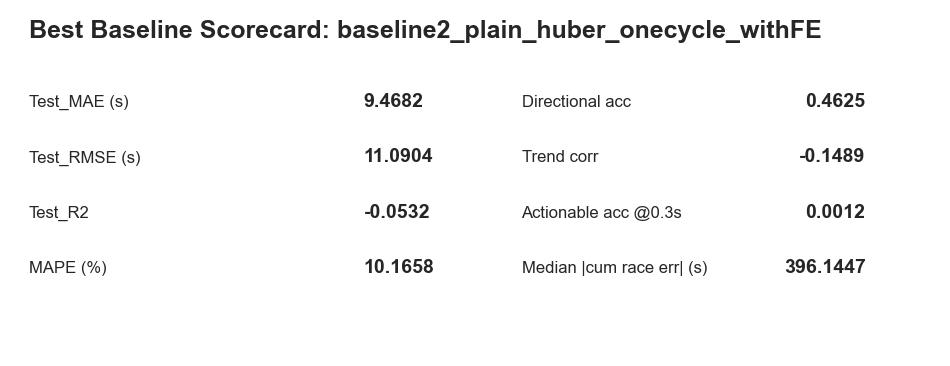

In [12]:
results = []

# Baseline 0: match the originally described model/training as closely as possible
baseline0_cfg = ExperimentConfig(
    name='baseline0_legacy_mse_nosched_noFE',
    use_feature_engineering=False,
    arch='legacy',
    loss='mse',
    scheduler='none',
    dropout=0.2,
    emb_dropout=0.0,
    lr=1e-3,
    weight_decay=1e-4,
    label_noise=0.0,
    clip_norm=1.0,
    epochs=40,
)

# PART 1 isolation: same baseline but with engineered features enabled
baseline1_cfg = ExperimentConfig(
    name='baseline1_legacy_mse_nosched_withFE',
    use_feature_engineering=True,
    arch='legacy',
    loss='mse',
    scheduler='none',
    dropout=0.2,
    emb_dropout=0.0,
    lr=1e-3,
    weight_decay=1e-4,
    label_noise=0.0,
    clip_norm=1.0,
    epochs=40,
)

# Baseline 2: upgraded training recipe (Huber + OneCycle + stronger regularization)
baseline2_cfg = ExperimentConfig(
    name='baseline2_plain_huber_onecycle_withFE',
    use_feature_engineering=True,
    arch='baseline',
    loss='huber',
    huber_beta=1.0,
    scheduler='onecycle',
    dropout=0.30,
    emb_dropout=0.10,
    weight_decay=1e-3,
    epochs=40,
)

for cfg in [baseline0_cfg, baseline1_cfg, baseline2_cfg]:
    res, hist, pred = run_experiment(cfg)
    results.append(res)

results_df = pd.DataFrame(results).sort_values('Test_MAE')
display(results_df)

best = results_df.iloc[0].to_dict()
plot_model_quality_scorecard({
    'Test_MAE (s)': best['Test_MAE'],
    'Test_RMSE (s)': best['Test_RMSE'],
    'Test_R2': best['Test_R2'],
    'MAPE (%)': best['MAPE_pct'],
    'Directional acc': best['DirectionalAcc'],
    'Trend corr': best['TrendCorr'],
    'Actionable acc @0.3s': best['ActionableAcc@0.3'],
    'Median |cum race err| (s)': best['MedianAbsCumRaceErr_s'],
}, title=f"Best Baseline Scorecard: {best['Model']}")
plt.show()


## PART 2: Architecture Variants
Run each and compare against baseline.


variantA_residual_huber_onecycle | epoch 001 | train_loss=89.4719 | val_mae=80.885
variantA_residual_huber_onecycle | epoch 005 | train_loss=14.0116 | val_mae=5.075
variantA_residual_huber_onecycle | epoch 010 | train_loss=9.5591 | val_mae=4.165
variantA_residual_huber_onecycle | epoch 015 | train_loss=9.5349 | val_mae=2.228
variantA_residual_huber_onecycle | epoch 020 | train_loss=9.4330 | val_mae=6.460
Early stop at epoch 23 (best val_mae=2.228)


c:\Users\tvcar\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


variantB_attention_huber_onecycle | epoch 001 | train_loss=86.2398 | val_mae=74.743
variantB_attention_huber_onecycle | epoch 005 | train_loss=43.0063 | val_mae=18.467
variantB_attention_huber_onecycle | epoch 010 | train_loss=6.8641 | val_mae=0.855
variantB_attention_huber_onecycle | epoch 015 | train_loss=6.7099 | val_mae=1.566
variantB_attention_huber_onecycle | epoch 020 | train_loss=6.5586 | val_mae=1.222
variantB_attention_huber_onecycle | epoch 025 | train_loss=6.4149 | val_mae=0.746
Early stop at epoch 26 (best val_mae=0.573)
variantC_two_tower_huber_onecycle | epoch 001 | train_loss=88.0333 | val_mae=78.483
variantC_two_tower_huber_onecycle | epoch 005 | train_loss=11.3371 | val_mae=25.861
variantC_two_tower_huber_onecycle | epoch 010 | train_loss=6.3208 | val_mae=18.910
variantC_two_tower_huber_onecycle | epoch 015 | train_loss=6.1294 | val_mae=17.634
variantC_two_tower_huber_onecycle | epoch 020 | train_loss=5.9306 | val_mae=16.458
variantC_two_tower_huber_onecycle | epoch 0

,Model,Architecture,Params,Loss,Scheduler,TrainTime_min,Test_MAE,Test_RMSE,Test_R2,MAPE_pct,DirectionalAcc,TrendCorr,ActionableAcc@0.3,MedianAbsCumRaceErr_s
4,variantB_attention_huber_onecycle,attention,30661,huber,onecycle,1.545037,1.888447,3.554255,0.891829,1.989249,0.453480,-0.245235,0.171561,41.039176
3,variantA_residual_huber_onecycle,residual,1084105,huber,onecycle,0.390516,3.713946,5.957622,0.696081,3.826117,0.451732,-0.171587,0.093624,76.778799
2,baseline2_plain_huber_onecycle_withFE,baseline,55593,huber,onecycle,0.179239,9.468199,11.090444,-0.053199,10.165777,0.462527,-0.148897,0.001207,396.144723
5,variantC_two_tower_huber_onecycle,two_tower,72983,huber,onecycle,0.338176,13.550380,15.468399,-1.048817,14.483265,0.466845,-0.163741,0.000402,536.430598
1,baseline1_legacy_mse_nosched_withFE,legacy,55493,mse,none,0.211356,53.770006,54.982763,-24.886038,60.180373,0.466125,-0.146950,0.000000,2257.005325
0,baseline0_legacy_mse_nosched_noFE,legacy,50117,mse,none,0.206560,53.802095,56.011186,-25.863463,60.680618,0.492135,-0.135307,0.000000,2102.989178


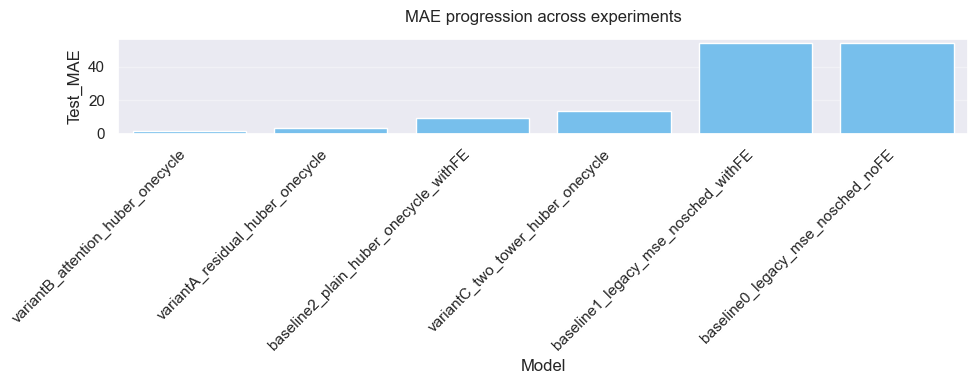

In [13]:
variant_cfgs = [
    ExperimentConfig(
        name='variantA_residual_huber_onecycle',
        use_feature_engineering=True,
        arch='residual',
        loss='huber',
        huber_beta=1.0,
        n_layers=4,
        hidden_dim=256,
        dropout=0.35,
        emb_dropout=0.10,
        weight_decay=2e-3,
        scheduler='onecycle',
        epochs=50,
    ),
    ExperimentConfig(
        name='variantB_attention_huber_onecycle',
        use_feature_engineering=True,
        arch='attention',
        loss='huber',
        huber_beta=1.0,
        n_layers=4,
        hidden_dim=256,
        dropout=0.25,
        emb_dropout=0.10,
        weight_decay=1e-3,
        scheduler='onecycle',
        epochs=50,
    ),
    ExperimentConfig(
        name='variantC_two_tower_huber_onecycle',
        use_feature_engineering=True,
        arch='two_tower',
        loss='huber',
        huber_beta=1.0,
        hidden_dim=256,
        dropout=0.30,
        emb_dropout=0.10,
        weight_decay=2e-3,
        scheduler='onecycle',
        epochs=50,
    ),
]

for cfg in variant_cfgs:
    res, hist, pred = run_experiment(cfg)
    results.append(res)

results_df = pd.DataFrame(results).sort_values('Test_MAE')
display(results_df)

plt.figure(figsize=(10,4))
sns.barplot(data=results_df, x='Model', y='Test_MAE', color='#64C4FF')
plt.xticks(rotation=45, ha='right')
plt.title('MAE progression across experiments')
plt.tight_layout()
plt.show()


## PART 3: Loss Function Experiments


In [14]:
loss_cfgs = [
    ExperimentConfig(
        name='loss_huber_beta0.5',
        use_feature_engineering=True,
        arch='residual',
        loss='huber',
        huber_beta=0.5,
        scheduler='onecycle',
        weight_decay=2e-3,
        dropout=0.35,
        epochs=40,
    ),
    ExperimentConfig(
        name='loss_log_cosh',
        use_feature_engineering=True,
        arch='residual',
        loss='log_cosh',
        scheduler='onecycle',
        weight_decay=2e-3,
        dropout=0.35,
        epochs=40,
    ),
    ExperimentConfig(
        name='loss_asymmetric_alpha0.7',
        use_feature_engineering=True,
        arch='residual',
        loss='asymmetric',
        asymmetric_alpha=0.7,
        scheduler='onecycle',
        weight_decay=2e-3,
        dropout=0.35,
        epochs=40,
    ),
    ExperimentConfig(
        name='loss_quantile_0.1_0.5_0.9',
        use_feature_engineering=True,
        arch='residual',
        loss='quantile',
        scheduler='onecycle',
        weight_decay=2e-3,
        dropout=0.35,
        epochs=50,
    ),
]

for cfg in loss_cfgs:
    res, hist, pred = run_experiment(cfg)
    results.append(res)

results_df = pd.DataFrame(results).sort_values('Test_MAE')
display(results_df)


loss_huber_beta0.5 | epoch 001 | train_loss=89.6692 | val_mae=80.600
loss_huber_beta0.5 | epoch 005 | train_loss=12.9090 | val_mae=10.612
loss_huber_beta0.5 | epoch 010 | train_loss=9.7823 | val_mae=7.399
loss_huber_beta0.5 | epoch 015 | train_loss=9.6959 | val_mae=6.572
loss_huber_beta0.5 | epoch 020 | train_loss=9.6661 | val_mae=6.825
loss_huber_beta0.5 | epoch 025 | train_loss=9.5231 | val_mae=4.657
loss_huber_beta0.5 | epoch 030 | train_loss=9.4817 | val_mae=5.304
Early stop at epoch 31 (best val_mae=4.041)


ValueError: Input contains NaN.

## PART 4: Training Dynamics Optimization


In [ ]:
dyn_cfgs = [
    ExperimentConfig(
        name='dyn_cosine_warm_restarts',
        use_feature_engineering=True,
        arch='residual',
        loss='huber',
        huber_beta=1.0,
        scheduler='cosine_warm_restarts',
        lr=1e-3,
        weight_decay=3e-3,
        dropout=0.40,
        emb_dropout=0.15,
        clip_norm=1.0,
        label_noise=0.05,
        epochs=60,
    ),
    ExperimentConfig(
        name='dyn_higher_wd_lower_lr',
        use_feature_engineering=True,
        arch='residual',
        loss='huber',
        huber_beta=1.0,
        scheduler='onecycle',
        lr=7e-4,
        weight_decay=5e-3,
        dropout=0.40,
        emb_dropout=0.15,
        clip_norm=1.0,
        label_noise=0.05,
        epochs=60,
    ),
]

for cfg in dyn_cfgs:
    res, hist, pred = run_experiment(cfg)
    results.append(res)

results_df = pd.DataFrame(results).sort_values('Test_MAE')
display(results_df)


## PART 5: Hyperparameter Search with Optuna (optional)


In [ ]:
try:
    import optuna
    from optuna.pruners import MedianPruner
    from optuna.samplers import TPESampler
except Exception as e:
    print('Optuna not installed in this environment. Install with: pip install optuna')
    raise

# NOTE: This is a template. Running 100 trials on CPU can take hours.


In [ ]:
def objective(trial: 'optuna.Trial'):
    cfg = ExperimentConfig(
        name='optuna_trial',
        use_feature_engineering=True,
        arch=trial.suggest_categorical('arch', ['baseline','residual','two_tower']),
        loss=trial.suggest_categorical('loss', ['huber','log_cosh']),
        huber_beta=trial.suggest_float('huber_beta', 0.5, 2.0),
        hidden_dim=trial.suggest_categorical('hidden_dim', [128, 256, 384]),
        n_layers=trial.suggest_int('n_layers', 3, 6),
        dropout=trial.suggest_float('dropout', 0.15, 0.45),
        emb_multiplier=trial.suggest_float('emb_multiplier', 0.5, 1.5),
        emb_dropout=trial.suggest_float('emb_dropout', 0.05, 0.25),
        lr=trial.suggest_float('lr', 1e-4, 5e-3, log=True),
        weight_decay=trial.suggest_float('weight_decay', 1e-5, 1e-2, log=True),
        scheduler='onecycle',
        epochs=25,
    )

    res, _hist, _pred = run_experiment(cfg)
    trial.report(res['Test_MAE'], 0)
    return res['Test_MAE']

study = optuna.create_study(direction='minimize', sampler=TPESampler(seed=42), pruner=MedianPruner(n_startup_trials=5, n_warmup_steps=5))
study.optimize(objective, n_trials=30)

print('Best:', study.best_value, study.best_params)


## PART 6: Ensemble Strategy (template)


In [ ]:
# Template: average predictions across multiple seeds for the best config
BEST_NAME = results_df.iloc[0]['Model']
print('Current best (by Test_MAE):', BEST_NAME)

# Manually pick the best config name above and re-create it here for multi-seed training.


## PART 7: Final Comparison Table


In [ ]:
results_df = pd.DataFrame(results).sort_values('Test_MAE').reset_index(drop=True)
results_df['Improvement_vs_Baseline_pct'] = (
    (results_df.loc[results_df['Model']=='baseline0_legacy_mse_nosched_noFE','Test_MAE'].iloc[0] - results_df['Test_MAE'])
    / results_df.loc[results_df['Model']=='baseline0_legacy_mse_nosched_noFE','Test_MAE'].iloc[0]
    * 100
)

results_df


In [ ]:
plt.figure(figsize=(10,4))
order = results_df.sort_values('Test_MAE')
sns.pointplot(data=order, x='Model', y='Test_MAE', color='#64C4FF')
plt.xticks(rotation=45, ha='right')
plt.title('Progression of improvements (lower is better)')
plt.tight_layout()
plt.show()
